## Get Borough data

In [36]:
import pandas as pd
import re

df = pd.read_csv('./places_analysis_results.csv')
# Define the boroughs and their regex patterns
boroughs = {
    "Manhattan": r"\b(Manhattan|M)\b",
    "Brooklyn": r"\b(Brooklyn|B)\b",
    "Queens": r"\b(Queens|Q)\b",
    "Bronx": r"\b(Bronx|BX)\b",
    "Staten Island": r"\b(Staten Island|SI)\b"
}

In [37]:
def find_borough(address):
    if isinstance(address, str):  # Check if the address is a string
        for borough, pattern in boroughs.items():
            if re.search(pattern, address, re.IGNORECASE):
                return borough
    return 'Not Found'

In [38]:
# Load your DataFrame (assuming it's already loaded as df)
# Ensure the address column exists
if "Address line 2"  in df.columns:
    # Apply the find_borough function to the "Full Address" column
    df["borough"] = df["Address line 2"].apply(find_borough)

    # Save the updated data
    df.to_csv("updated_addresses_with_boroughs.csv", index=False)
    print("Boroughs added and saved to updated_addresses_with_boroughs.csv")
else:
    print("Column 'Full Address' not found in the file.")

Boroughs added and saved to updated_addresses_with_boroughs.csv


In [39]:
if "borough" in df.columns:
    notFound= len(df[df["borough"] == "Not Found"])
    print(notFound)
else:
    print("Coloumn Borough not found")

4130


In [42]:
# Import necessary libraries
import pandas as pd

# Read the updated addresses CSV file
updated_addresses_df = pd.read_csv('./updated_addresses_with_boroughs.csv')

# Display the first few rows to understand the structure
print("First few rows of the updated addresses data:")
print(updated_addresses_df.head())

# Function to determine borough based on latitude and longitude
def get_borough(lat, lon):
    # Placeholder for actual logic to determine borough
    # This could be a lookup or a call to an external API
    return "Determined Borough"  # Replace with actual logic

# Apply changes only on rows where 'Borough' is 'Not Found'
mask = updated_addresses_df['borough'] == 'Not Found'
updated_addresses_df.loc[mask, 'borough'] = updated_addresses_df.loc[mask].apply(
    lambda row: get_borough(row['Latitude'], row['Longitude']), axis=1
)

# Display the updated DataFrame
print("\nUpdated borough details:")
print(updated_addresses_df["borough"].value_counts())

First few rows of the updated addresses data:
                       Address line 1              Address line 2  \
0          217 W 57th St Unit 127/128         Manhattan, NY 10019   
1  764 Saint Nicholas /C2 Ave Unit C1          New York, NY 10031   
2                        34 W 89th St         Manhattan, NY 10024   
3                     177 Benedict Rd     Staten Island, NY 10304   
4                     115-30 116th St  South Ozone Park, NY 11420   

                                        Full Address   Latitude  Longitude  \
0    217 W 57th St Unit 127/128 Manhattan, NY 10019   40.766474 -73.981266   
1  764 Saint Nicholas /C2 Ave Unit C1 New York, N...  40.826130 -73.943006   
2                  34 W 89th St Manhattan, NY 10024   40.787587 -73.969240   
3           177 Benedict Rd Staten Island, NY 10304   40.595008 -74.106434   
4        115-30 116th St South Ozone Park, NY 11420   40.675746 -73.822413   

   Number_of_Parks_Nearby  Distance_to_Nearest_Parks_miles  \
0       

In [47]:
import time
import pandas as pd
import json
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Load your dataset
df = pd.read_csv("./updated_addresses_with_boroughs.csv")

# Initialize the geolocator
geolocator = Nominatim(user_agent="geo_borough_finder")

# Progress tracking file
progress_file = "progress.json"

# Load progress if available
try:
    with open(progress_file, "r") as f:
        progress = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    progress = {}

def get_borough(lat, lon):
    try:
        lat, lon = float(lat), float(lon)
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location and 'address' in location.raw:
            address = location.raw['address']
            time.sleep(1)  # Avoid rate limits
            return address.get('borough', address.get('city', 'Unknown'))
    except ValueError:
        return "Invalid Coordinates"
    except GeocoderTimedOut:
        return "Timeout"
    return "Not Found"

# Ensure latitude and longitude are valid
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

batch_size = 10  # Adjust based on rate limits
updated_rows = []
for index, row in df.iterrows():
    if row['borough'] == "Not Found":
        lat, lon = row['Latitude'], row['Longitude']
        key = f"{lat},{lon}"
        
        if key in progress:
            borough = progress[key]  # Use cached result
        else:
            borough = get_borough(lat, lon)
            progress[key] = borough
        
        df.at[index, 'borough'] = borough
        updated_rows.append(row)
        
        if index % batch_size == 0:
            with open(progress_file, "w") as f:
                json.dump(progress, f)
            df.to_csv("updated_data.csv", index=False)

# Save the updated DataFrame
updated_df = pd.DataFrame(updated_rows)
updated_df.to_csv("newly_updated_values.csv", index=False)  # Save only newly updated values
df.to_csv("updated_data.csv", index=False)  # Save full updated dataset
with open(progress_file, "w") as f:
    json.dump(progress, f)

print("Updated boroughs saved to updated_data.csv")
print("Newly updated values saved to newly_updated_values.csv")


Updated boroughs saved to updated_data.csv
Newly updated values saved to newly_updated_values.csv


borough
Manhattan        3854
Brooklyn         2815
Queens           2054
Staten Island    1198
Bronx            1164
Name: count, dtype: int64


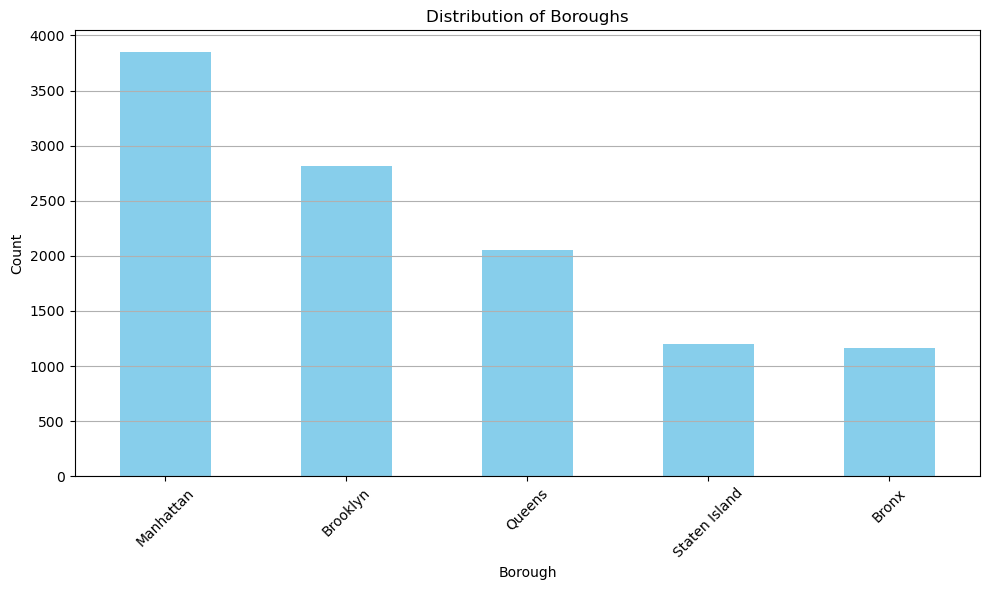

In [49]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the updated addresses CSV file
updated_addresses_df = pd.read_csv('./updated_data.csv')

# Display the first few rows to understand the structure
print(updated_addresses_df['borough'].value_counts())
updated_addresses_df['borough'] = updated_addresses_df['borough'].replace('The Bronx', 'Bronx')

values_to_remove = [
    "Invalid Coordinates",
    "Unknown",
    "City of Rochester",
    "City of Niagara Falls",
    "City of Yonkers"
]

# Remove rows with specified values in the Borough column
updated_addresses_df = updated_addresses_df[~updated_addresses_df['borough'].isin(values_to_remove)]

# Plotting the histogram of boroughs
plt.figure(figsize=(10, 6))
updated_addresses_df['borough'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

updated_addresses_df.to_csv('./updated_data.csv', index=False)

# Random Forest Eval

In [77]:
# Check how many rows have the same value in the 'Address Line 1' and 'Address Line 2' attributes in both updated_data.csv and realtor 11k.csv
realtor_df = pd.read_csv('./data/realtor 11k.csv')
places_df = pd.read_csv('updated_data.csv')

# Check how many rows have the same value in the 'Address Line 1' attribute
same_values_address_line_1 = realtor_df["Address line 1"].isin(places_df["Address line 1"]).sum()
print(f"There are {same_values_address_line_1} rows with the same 'Address Line 1' value in both dataframes.")

# Check how many rows have the same value in the 'Address Line 2' attribute
same_values_address_line_2 = realtor_df["Address line 2"].isin(places_df["Address line 2"]).sum()
print(f"There are {same_values_address_line_2} rows with the same 'Address Line 2' value in both dataframes.")



print("Realtor lenght: ",len(realtor_df))
print("Places lenght: ",len(places_df))

There are 11086 rows with the same 'Address Line 1' value in both dataframes.
There are 11086 rows with the same 'Address Line 2' value in both dataframes.
Realtor lenght:  11110
Places lenght:  11085


Total duplicates found along 'Latitude' and 'Longitude': 6623
Total duplicates after removal: 0
Categorical Columns:
['borough']
Numerical Columns:
['Latitude', 'Longitude', 'Number_of_Parks_Nearby', 'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby', 'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby', 'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby', 'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby', 'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby', 'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby', 'Distance_to_Nearest_Colleges_miles', 'Number_of_Universities_Nearby', 'Distance_to_Nearest_Universities_miles', 'Number_of_Buses_Nearby', 'Distance_to_Nearest_Buses_miles', 'Number_of_Trains_Nearby', 'Distance_to_Nearest_Trains_miles', 'Number_of_Airports_Nearby', 'Distance_to_Nearest_Airports_miles', 'Number_of_Museums_Nearby', 'Distance_to_Nearest_Museums_miles', 'Number_of_Libraries_Nearby', 'Distance_to_N

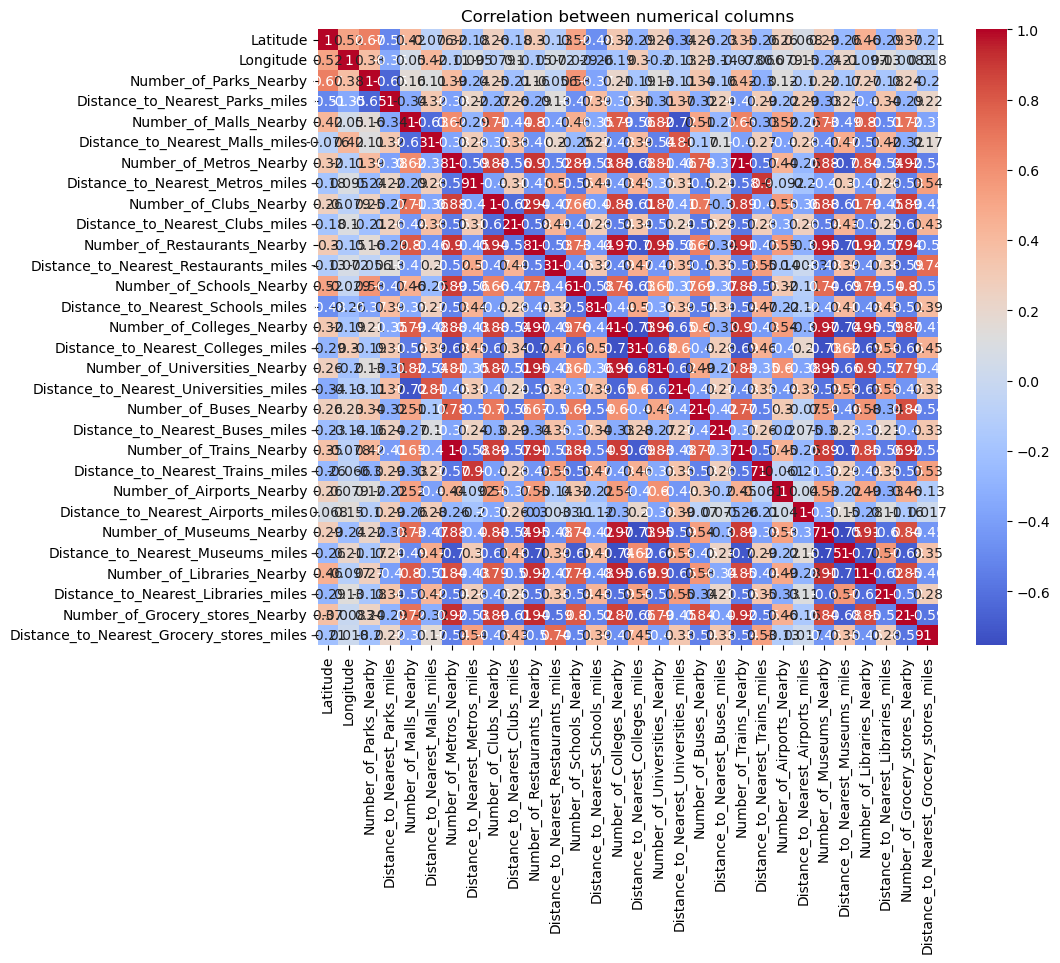

In [68]:
import pandas as pd
data = pd.read_csv("./updated_data.csv")

# Identify and display all missing values in the dataset
missing_values = data.isnull().sum()
# print("Missing Values in the Dataset:")
# print(missing_values)

# Identify duplicates along "Latitude" and "Longitude"
duplicates = data.duplicated(subset=["Latitude", "Longitude"], keep=False)
print(f"Total duplicates found along 'Latitude' and 'Longitude': {duplicates.sum()}")


# Remove duplicates from the dataset
data = data.drop_duplicates(subset=["Latitude", "Longitude"], keep="first")

# Verify if all duplicates have been removed
duplicates_after_removal = data.duplicated(subset=["Latitude", "Longitude"], keep=False).sum()
print(f"Total duplicates after removal: {duplicates_after_removal}")


# Identify categorical values in the dataset
categorical_columns=['borough']
numerical_columns = ['Latitude', 'Longitude', 'Number_of_Parks_Nearby',
       'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby',
       'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby',
       'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby',
       'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby',
       'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby',
       'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby',
       'Distance_to_Nearest_Colleges_miles', 'Number_of_Universities_Nearby',
       'Distance_to_Nearest_Universities_miles', 'Number_of_Buses_Nearby',
       'Distance_to_Nearest_Buses_miles', 'Number_of_Trains_Nearby',
       'Distance_to_Nearest_Trains_miles', 'Number_of_Airports_Nearby',
       'Distance_to_Nearest_Airports_miles', 'Number_of_Museums_Nearby',
       'Distance_to_Nearest_Museums_miles', 'Number_of_Libraries_Nearby',
       'Distance_to_Nearest_Libraries_miles',
       'Number_of_Grocery_stores_Nearby',
       'Distance_to_Nearest_Grocery_stores_miles']
print("Categorical Columns:")
print(categorical_columns)

# Identify numerical values in the dataset
print("Numerical Columns:")
print(numerical_columns)

# Calculate the correlation between the numerical columns
correlation = data[numerical_columns].corr()

# Visualize the correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between numerical columns')
plt.show()


